In [1]:
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Electric_Production.csv')

In [3]:
df.rename(columns = {"DATE":"Date","IPG2211A2N":"Electricity"},inplace = True)

In [4]:
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format = True)
df = df.set_index(["Date"])

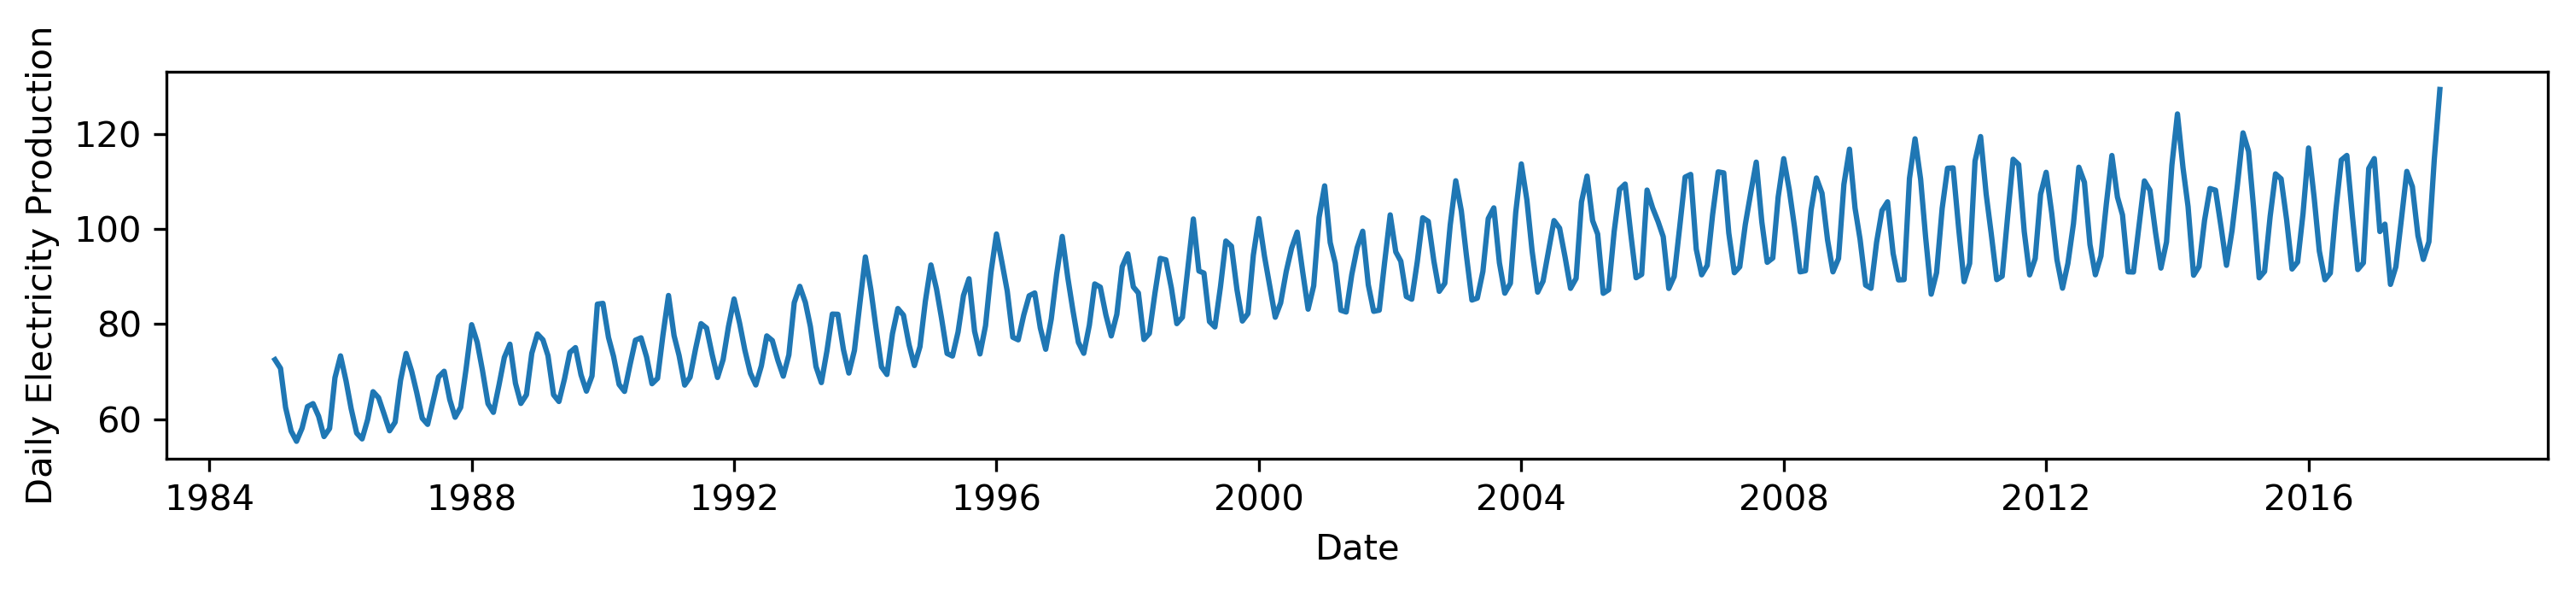

In [5]:
plt.figure(figsize=(12,2),dpi=300)
plt.ylabel("Daily Electricity Production")
plt.xlabel("Date")
plt.plot(df)
# plt.savefig('elec')
plt.show()

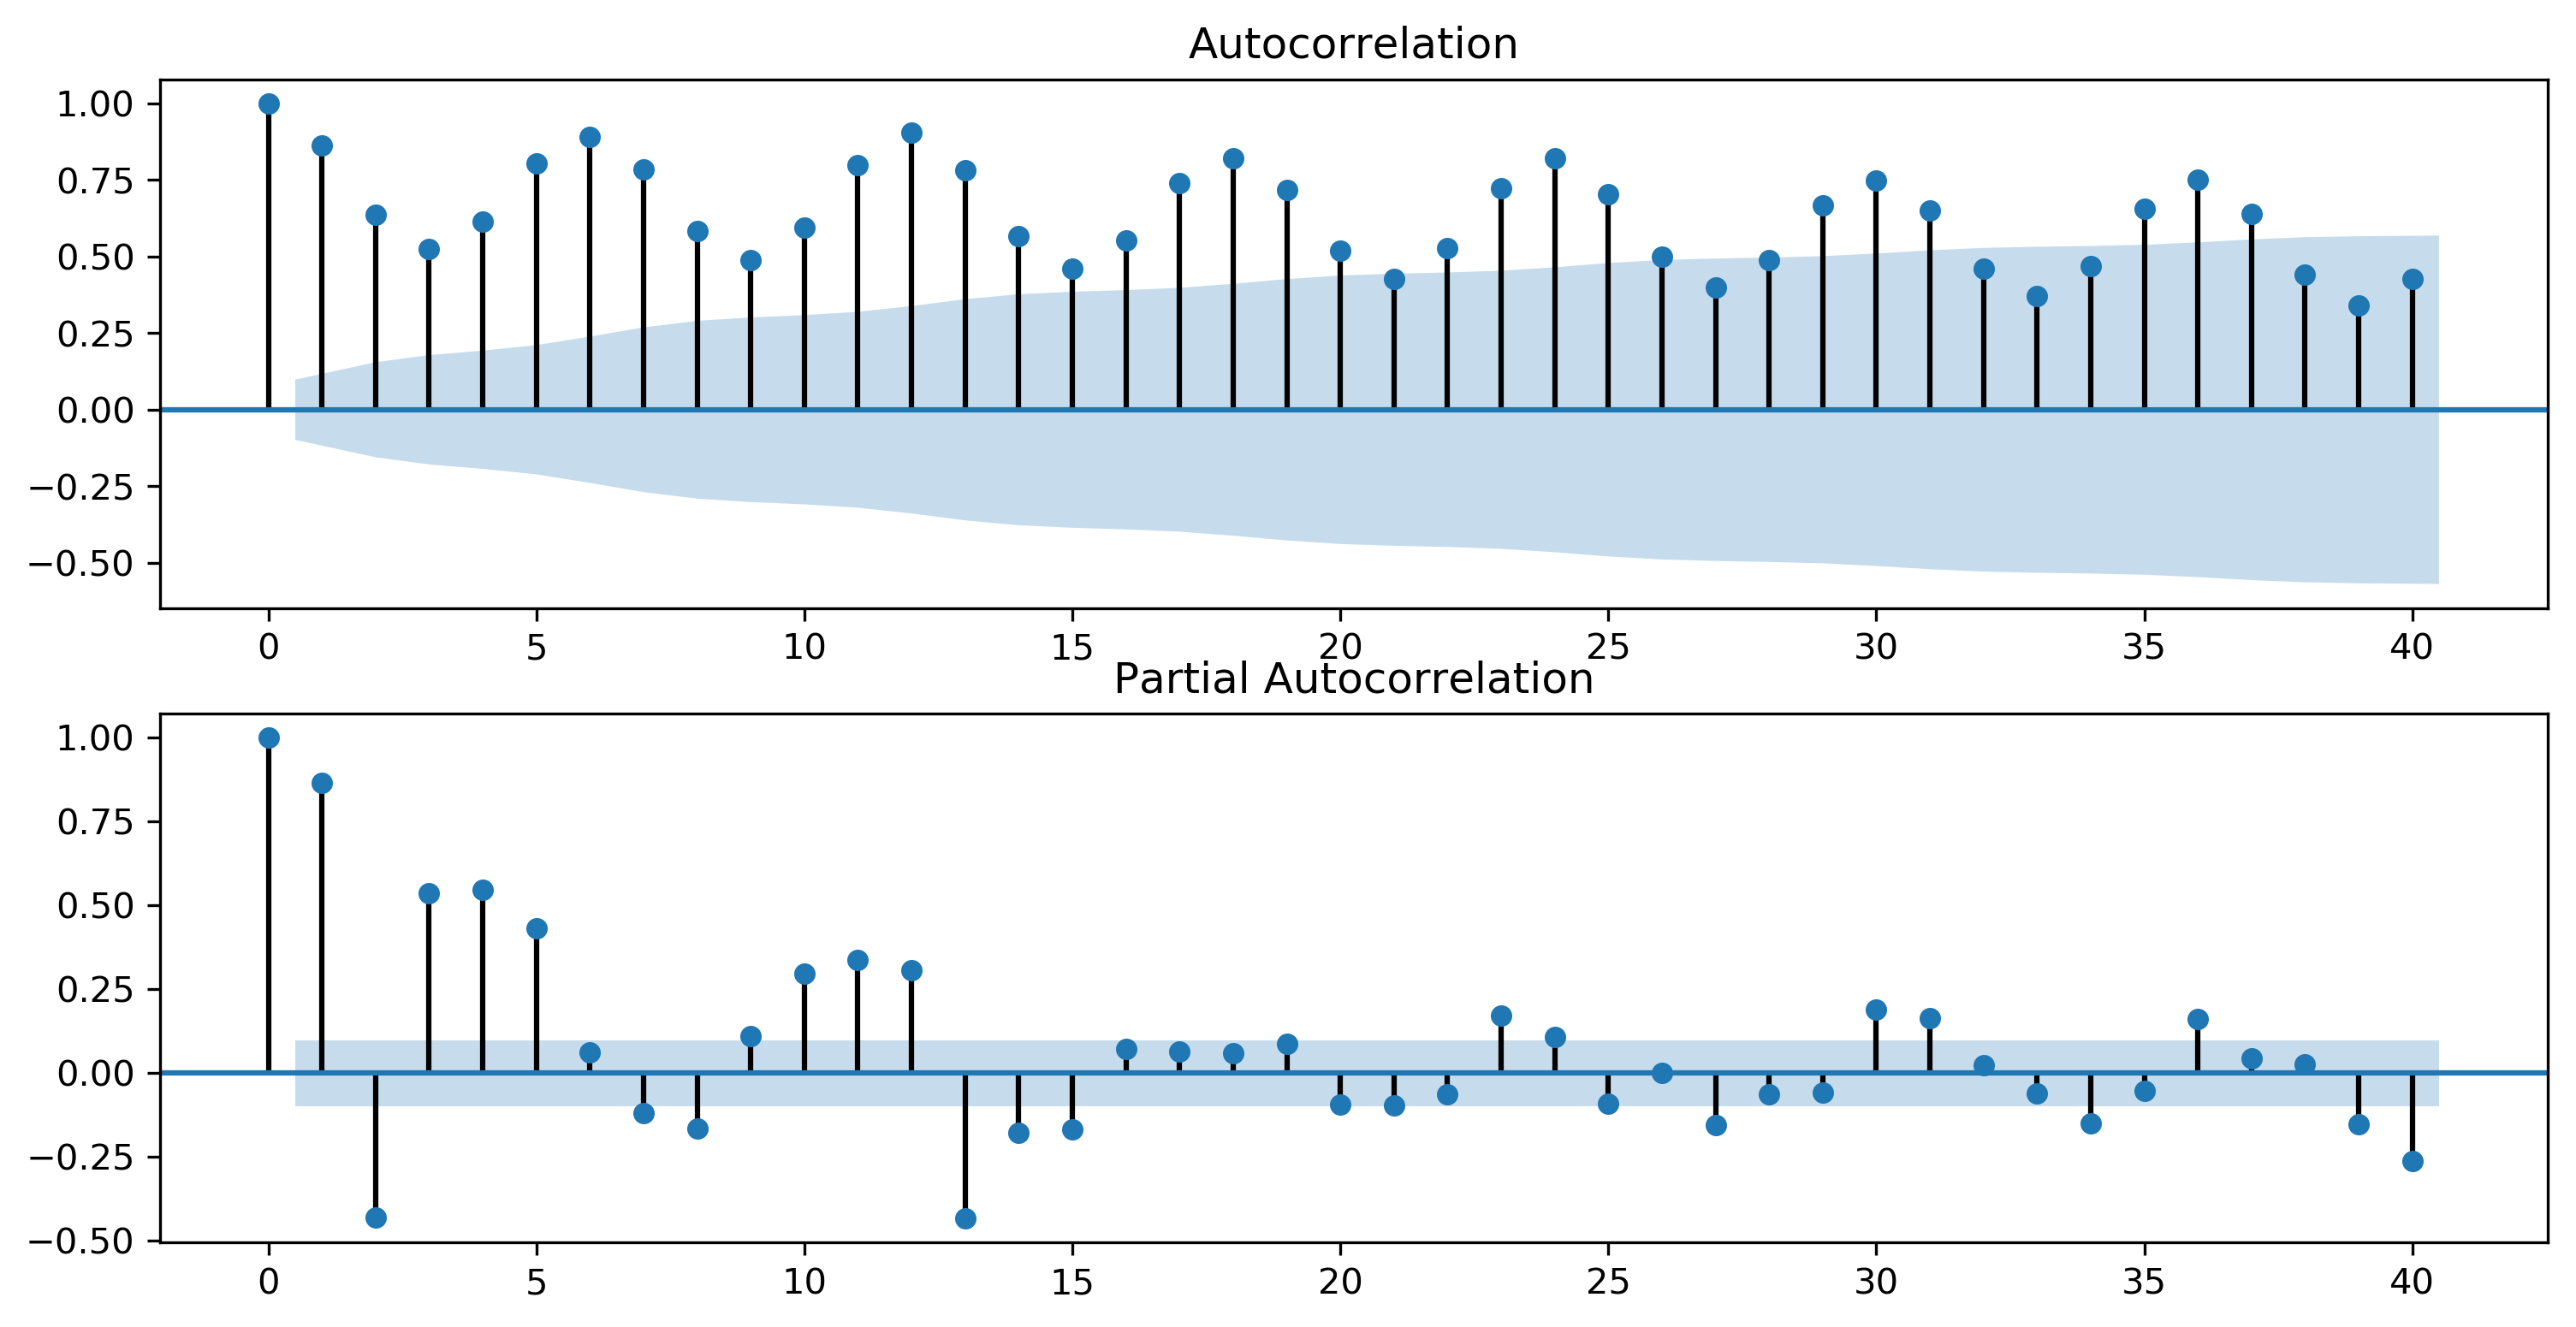

In [52]:
fig = plt.figure(figsize=(12,6),dpi=300)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)
plt.savefig('elec_acf_pacf')
plt.show()

In [7]:
train_data = df[:int(0.8*len(df))]
valid_data = df[int(0.8*len(df)):int(0.9*len(df))]
test_data = df[int(0.9*len(df)):]


In [9]:
valid_data.shape

(40, 1)

In [55]:
stat_df = pd.DataFrame(df.Electricity.diff(12).dropna())

In [386]:
stat_train_data = stat_df[:len(stat_df)-97]
stat_test_data = stat_df[len(stat_df)-97:]

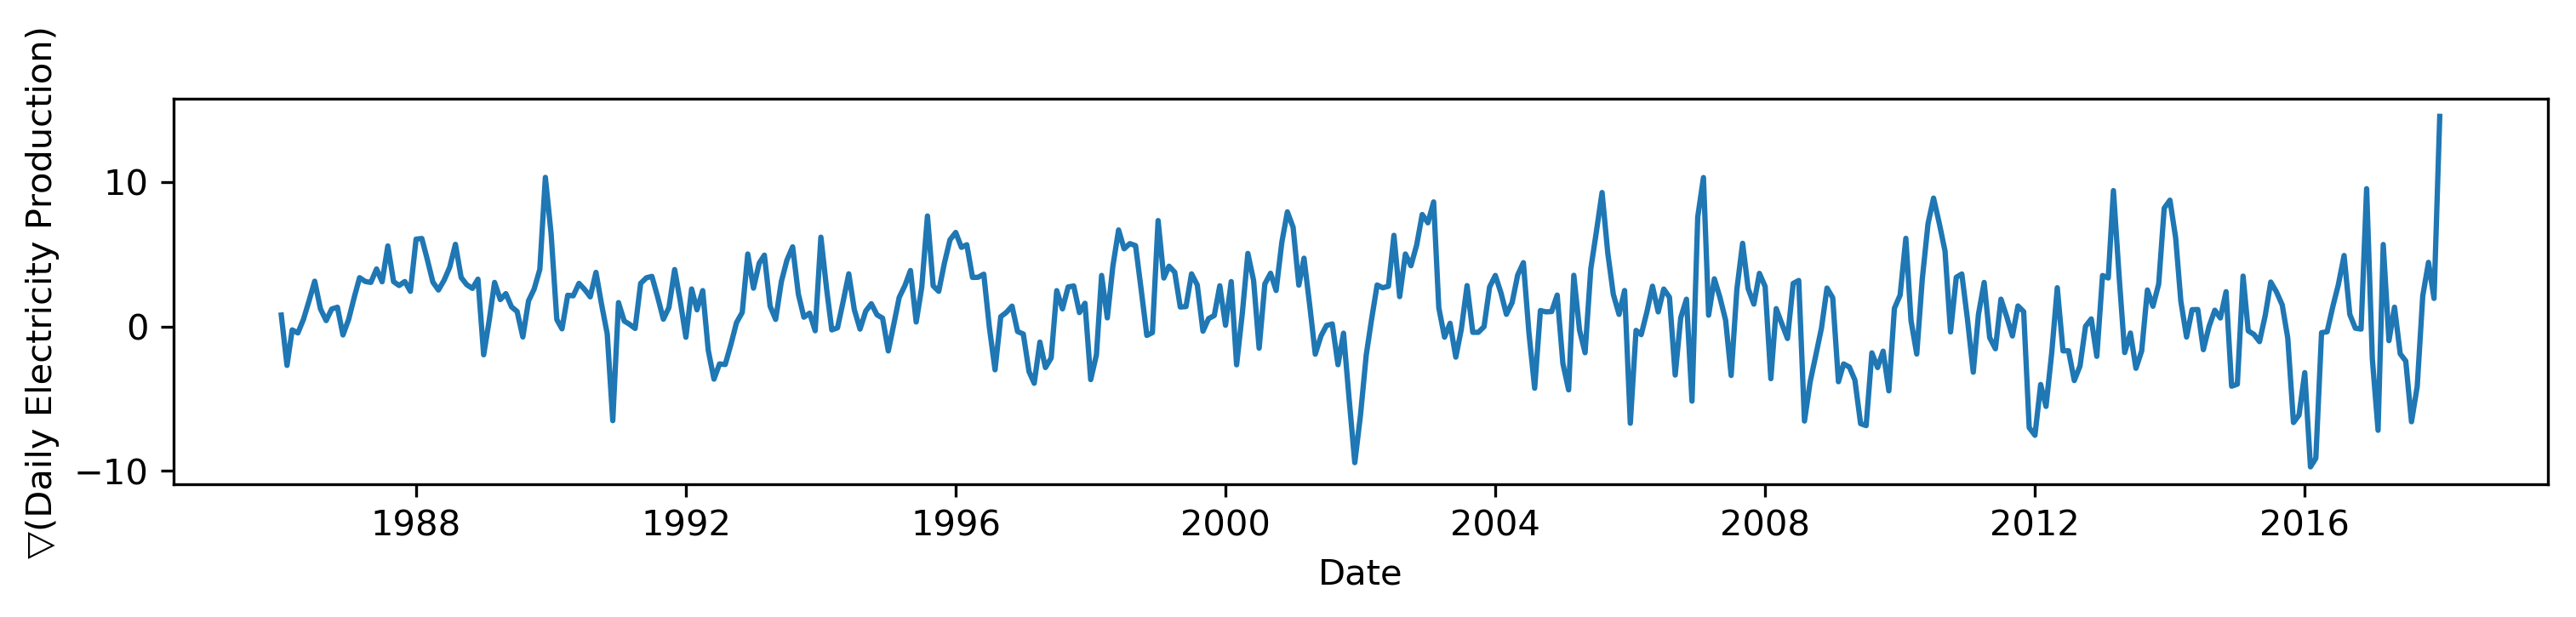

In [434]:

plt.figure(figsize=(12,2),dpi=300)
plt.ylabel("▽(Daily Electricity Production)")
plt.xlabel("Date")
plt.plot(stat_df)
plt.savefig('elec_diff')
plt.show()

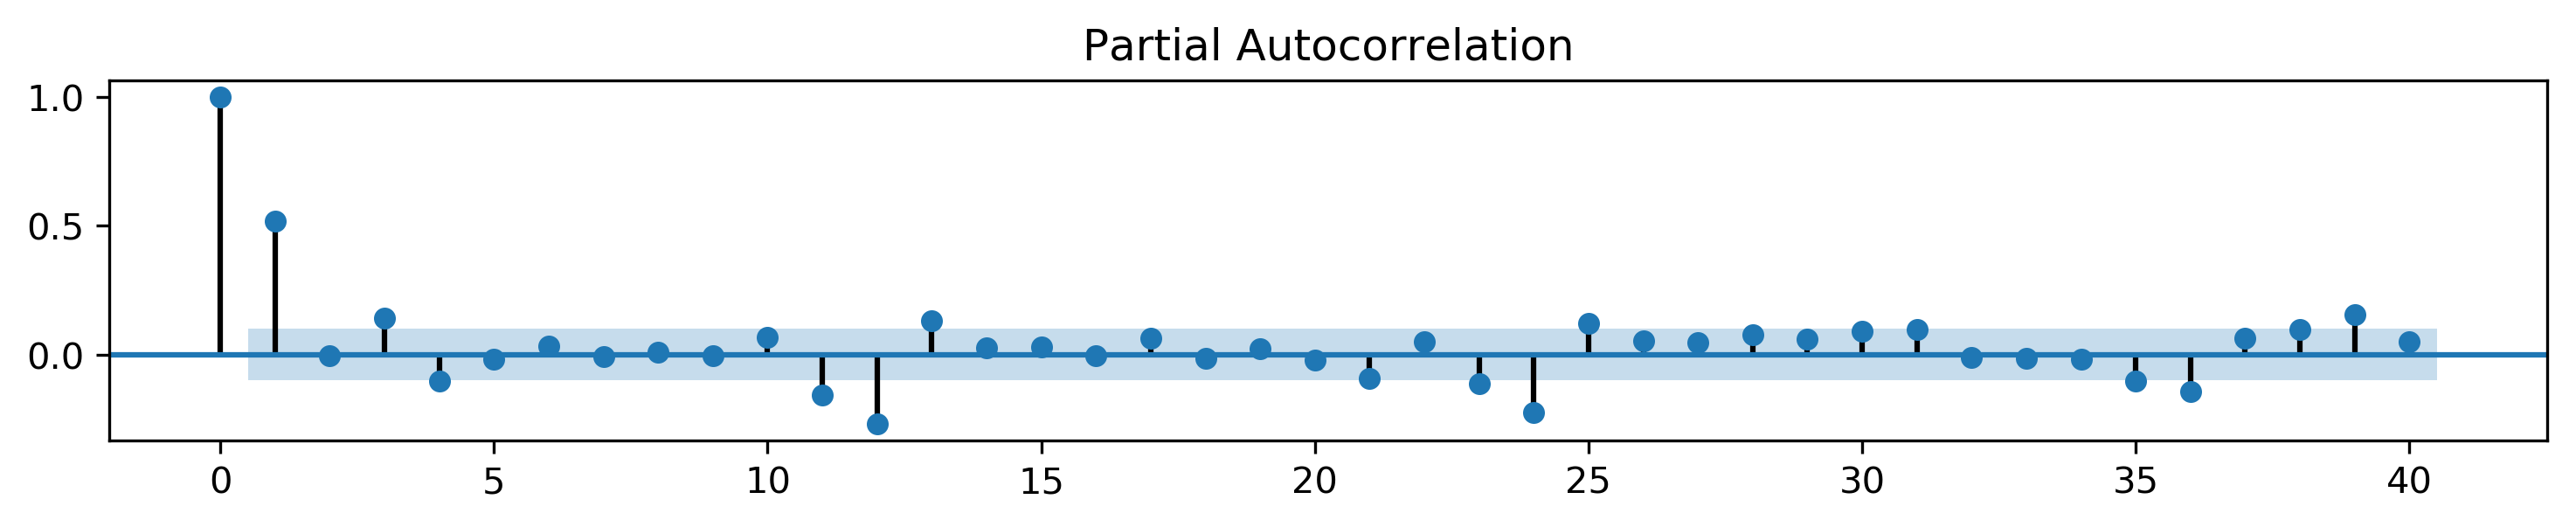

In [451]:
fig = plt.figure(figsize=(12,4),dpi=300)
ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(stat_df, lags=40, ax=ax2)
plt.savefig('elec_diff_pacf')


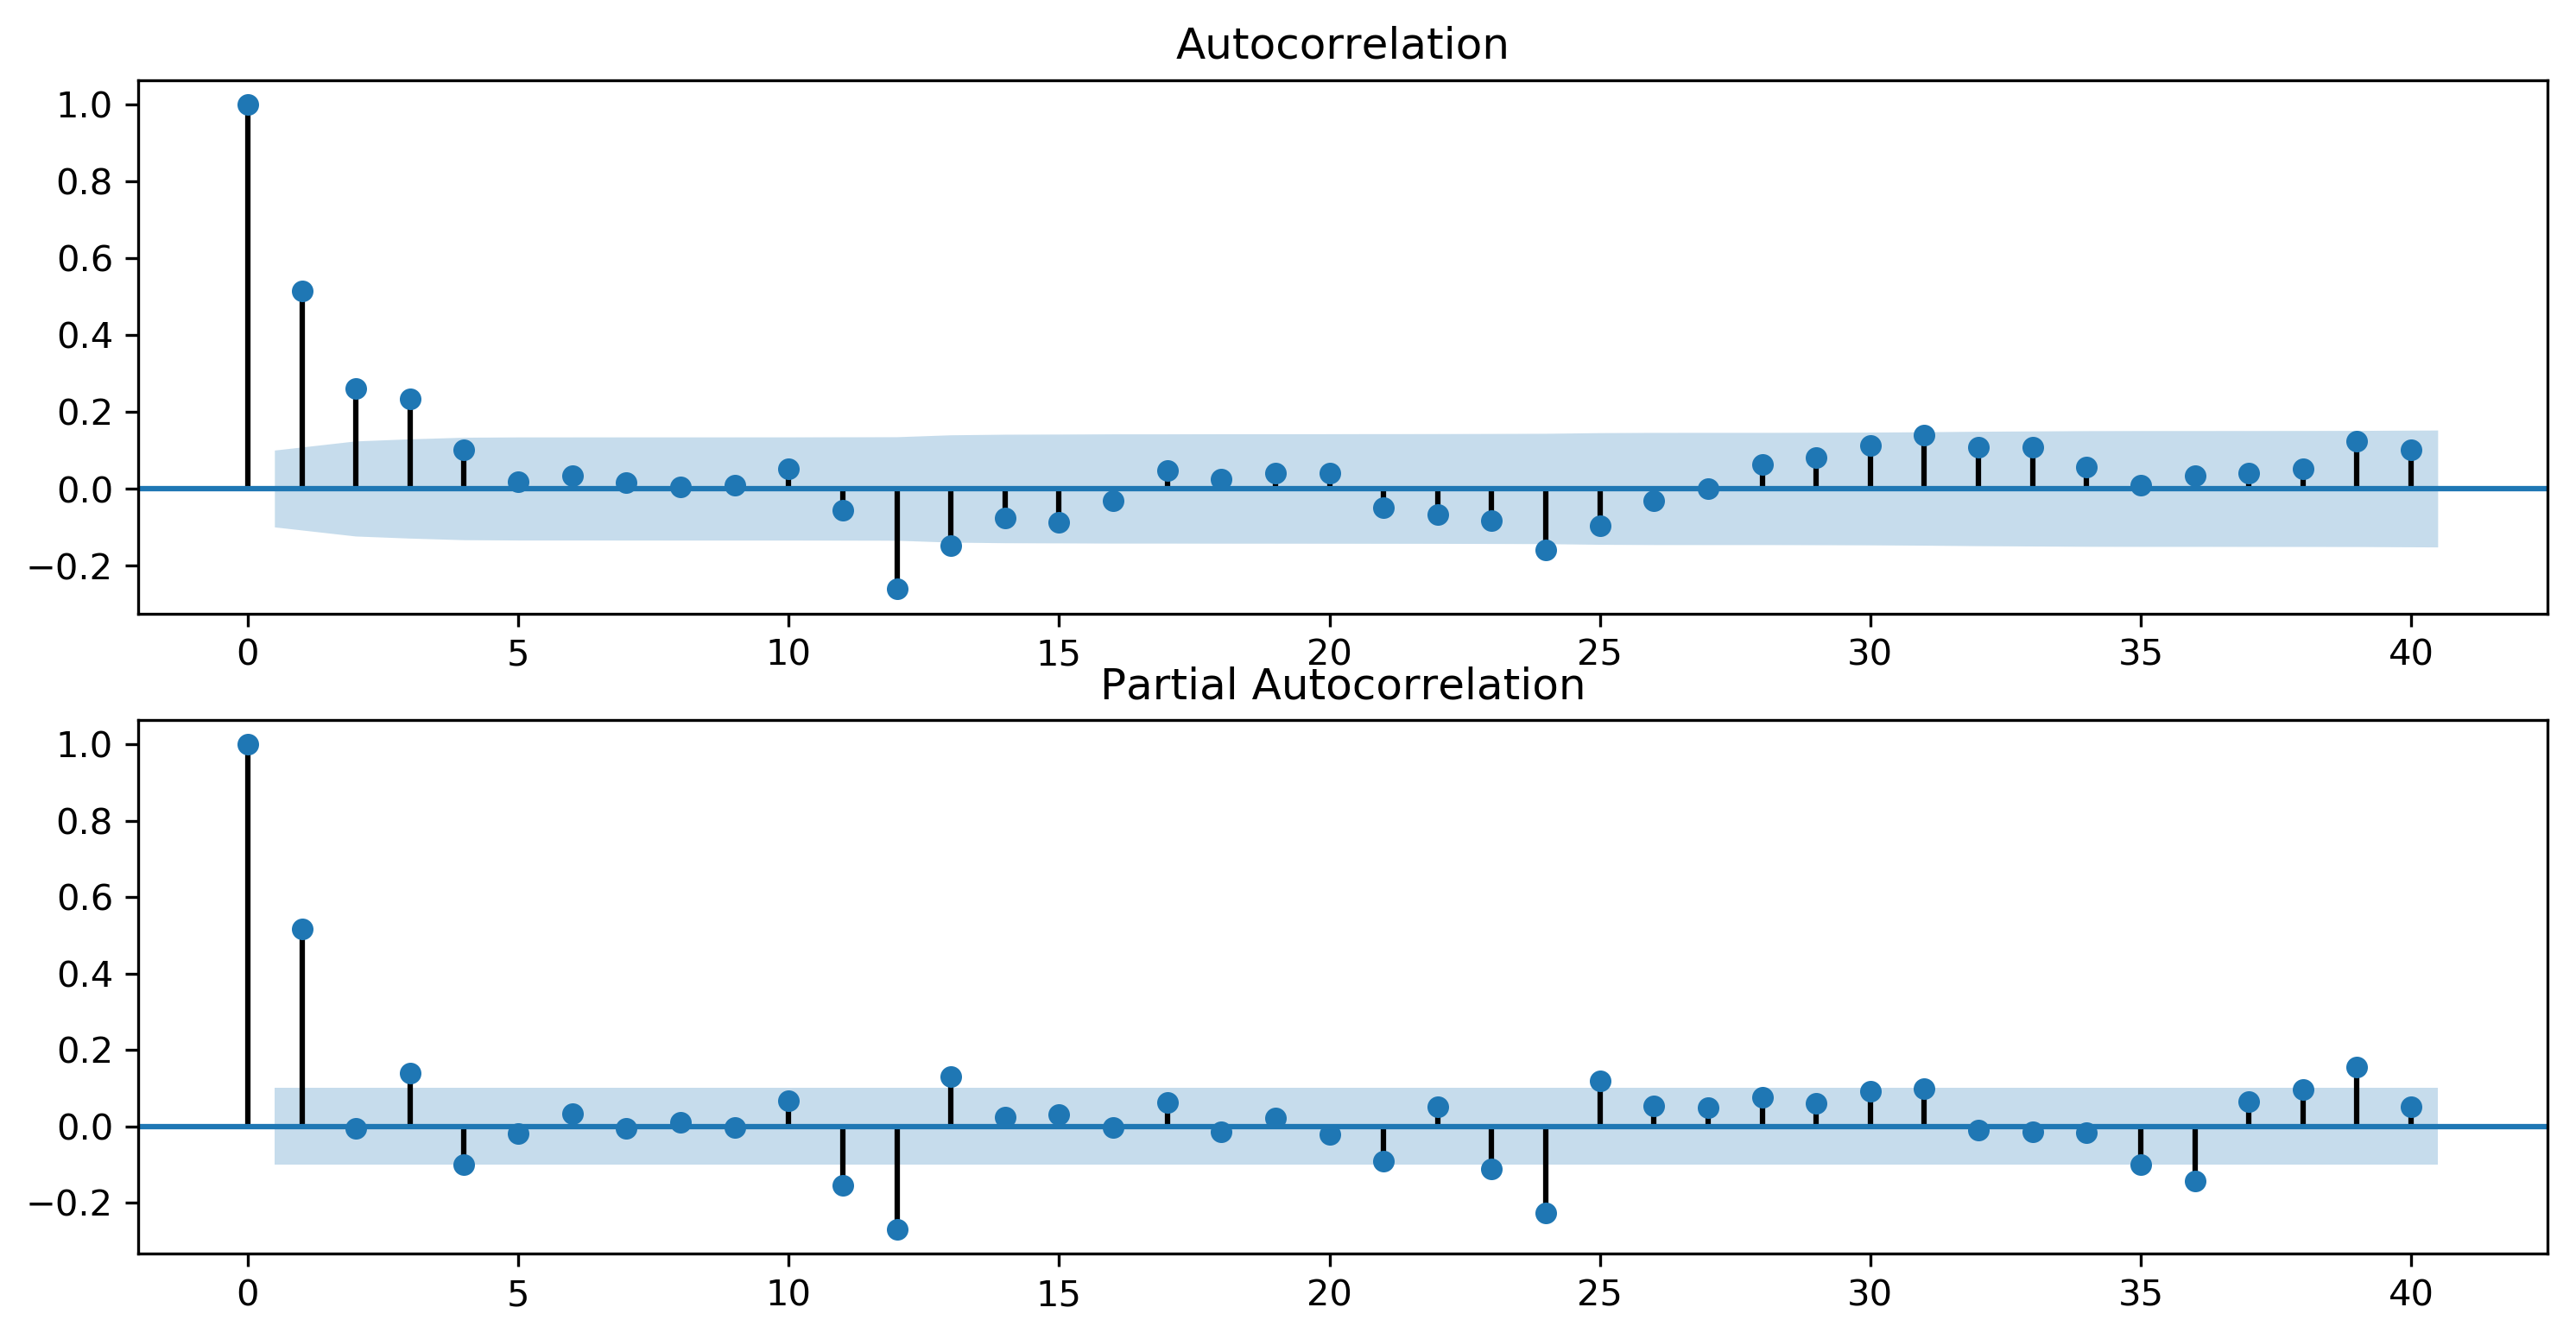

In [56]:
fig = plt.figure(figsize=(12,6),dpi=300)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stat_df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stat_df, lags=40, ax=ax2)
plt.savefig('elec_diff_acf_pacf')
plt.show()

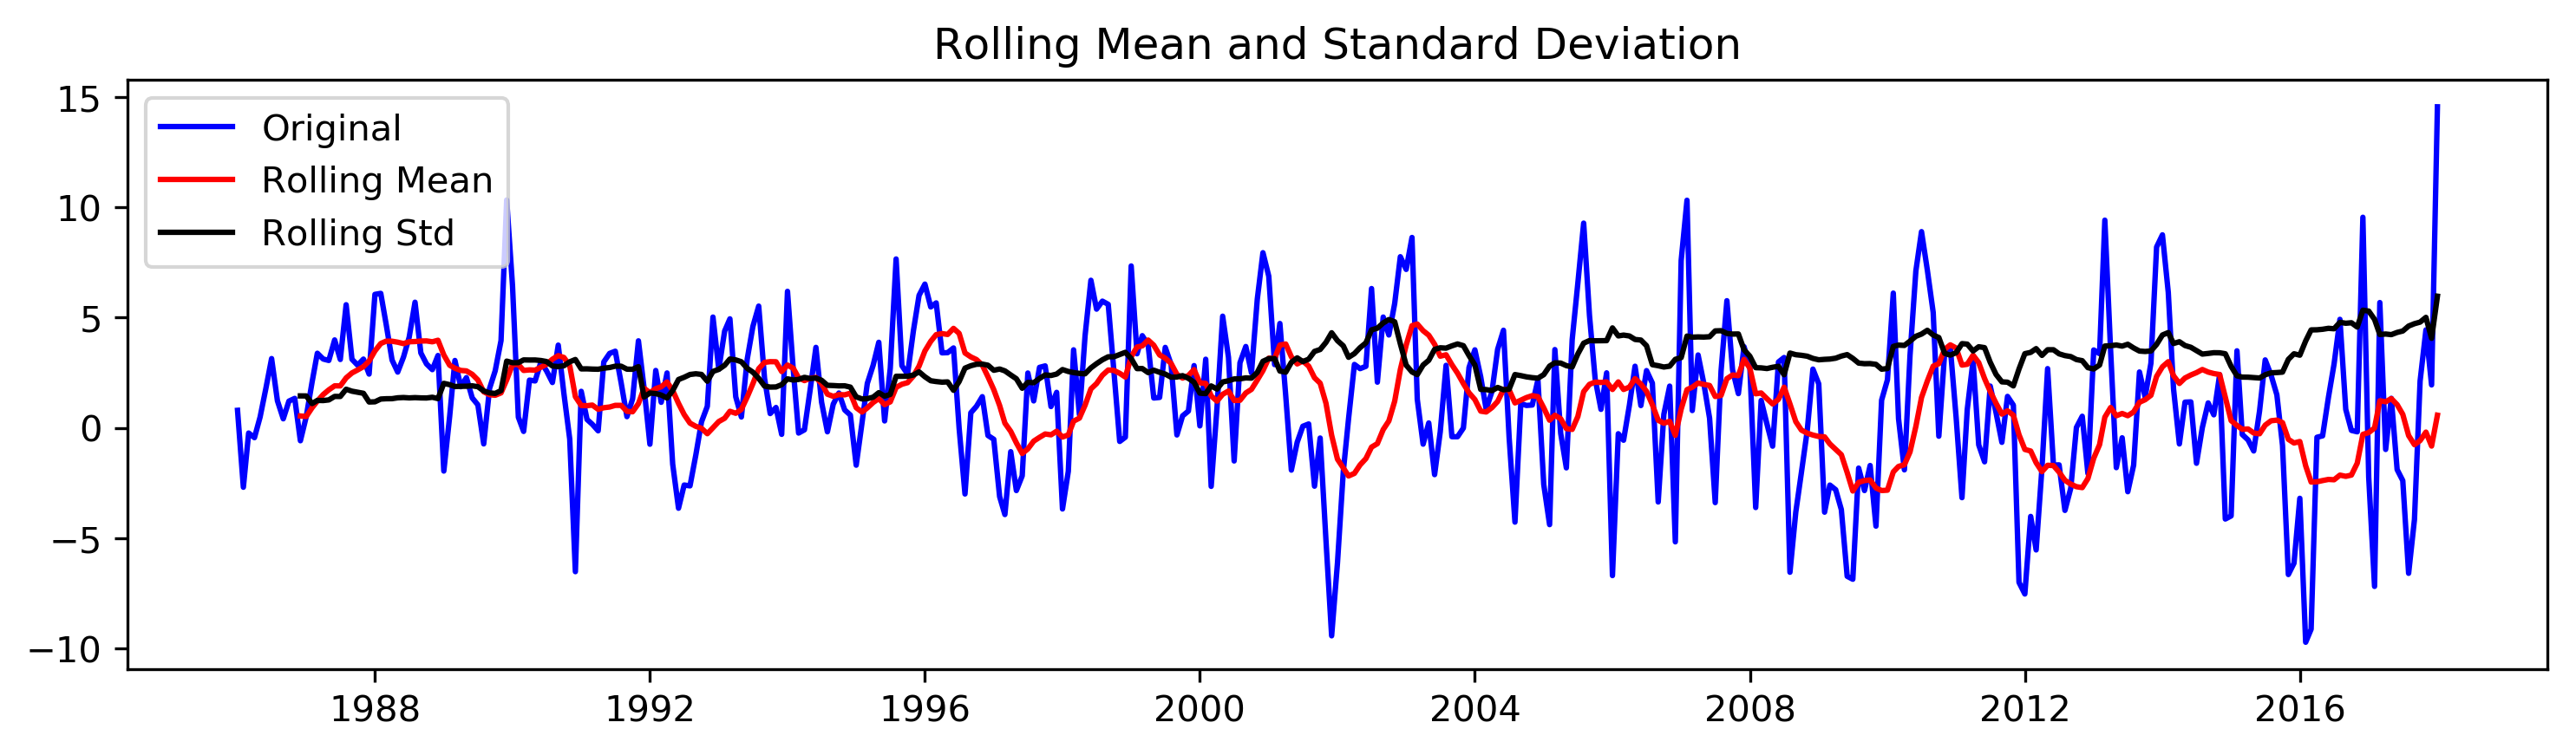

Results of dickey fuller test


,0
Test Statistics,-5.673482e+00
p-value,8.812645e-07
No. of lags used,1.200000e+01
Number of observations used,3.720000e+02
critical value (1%),-3.448052e+00
critical value (5%),-2.869341e+00
critical value (10%),-2.570926e+00


<Figure size 432x288 with 0 Axes>

In [449]:
from statsmodels.tsa.stattools import adfuller


#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize = (12,3),dpi=300)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    plt.savefig('elec_diff_roll')
    
    #null hypo: data is non-stationary
    print("Results of dickey fuller test")
    adft = adfuller(timeseries.dropna(),autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
#     print(pd.DataFrame(output))
    return pd.DataFrame(output)
    
test_stationarity(stat_df.Electricity)

In [42]:
model = SARIMAX(train_data, order=(2,1,0), seasonal_order=(2,0,1,12)).fit()
# model = SARIMAX(stat_train_data, order=(1,1,2), seasonal_order=(1,1,1,6)).fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [43]:
pred = model.predict('2011-06','2014-09')

In [44]:
rmse = math.sqrt(mean_squared_error(valid_data.Electricity, pred.tolist()))
print('RMSE: '+str(rmse))
smape = np.mean(2*np.abs(pred.tolist()-valid_data.Electricity)/(np.abs(pred.tolist())+np.abs(valid_data.Electricity)))
print('SMAPE: '+str(smape))


RMSE: 2.957854021071689
SMAPE: 0.02180442717716253


In [403]:
# pred_back = [119]
# for diff in pred[1:]:
#     pred_back.append(pred_back[-1]+diff)

In [47]:
pred_test = model.predict('2014-10','2018-01')

In [58]:
import pickle
pickle.dump(s,open('elec_pred_list.p','wb'))

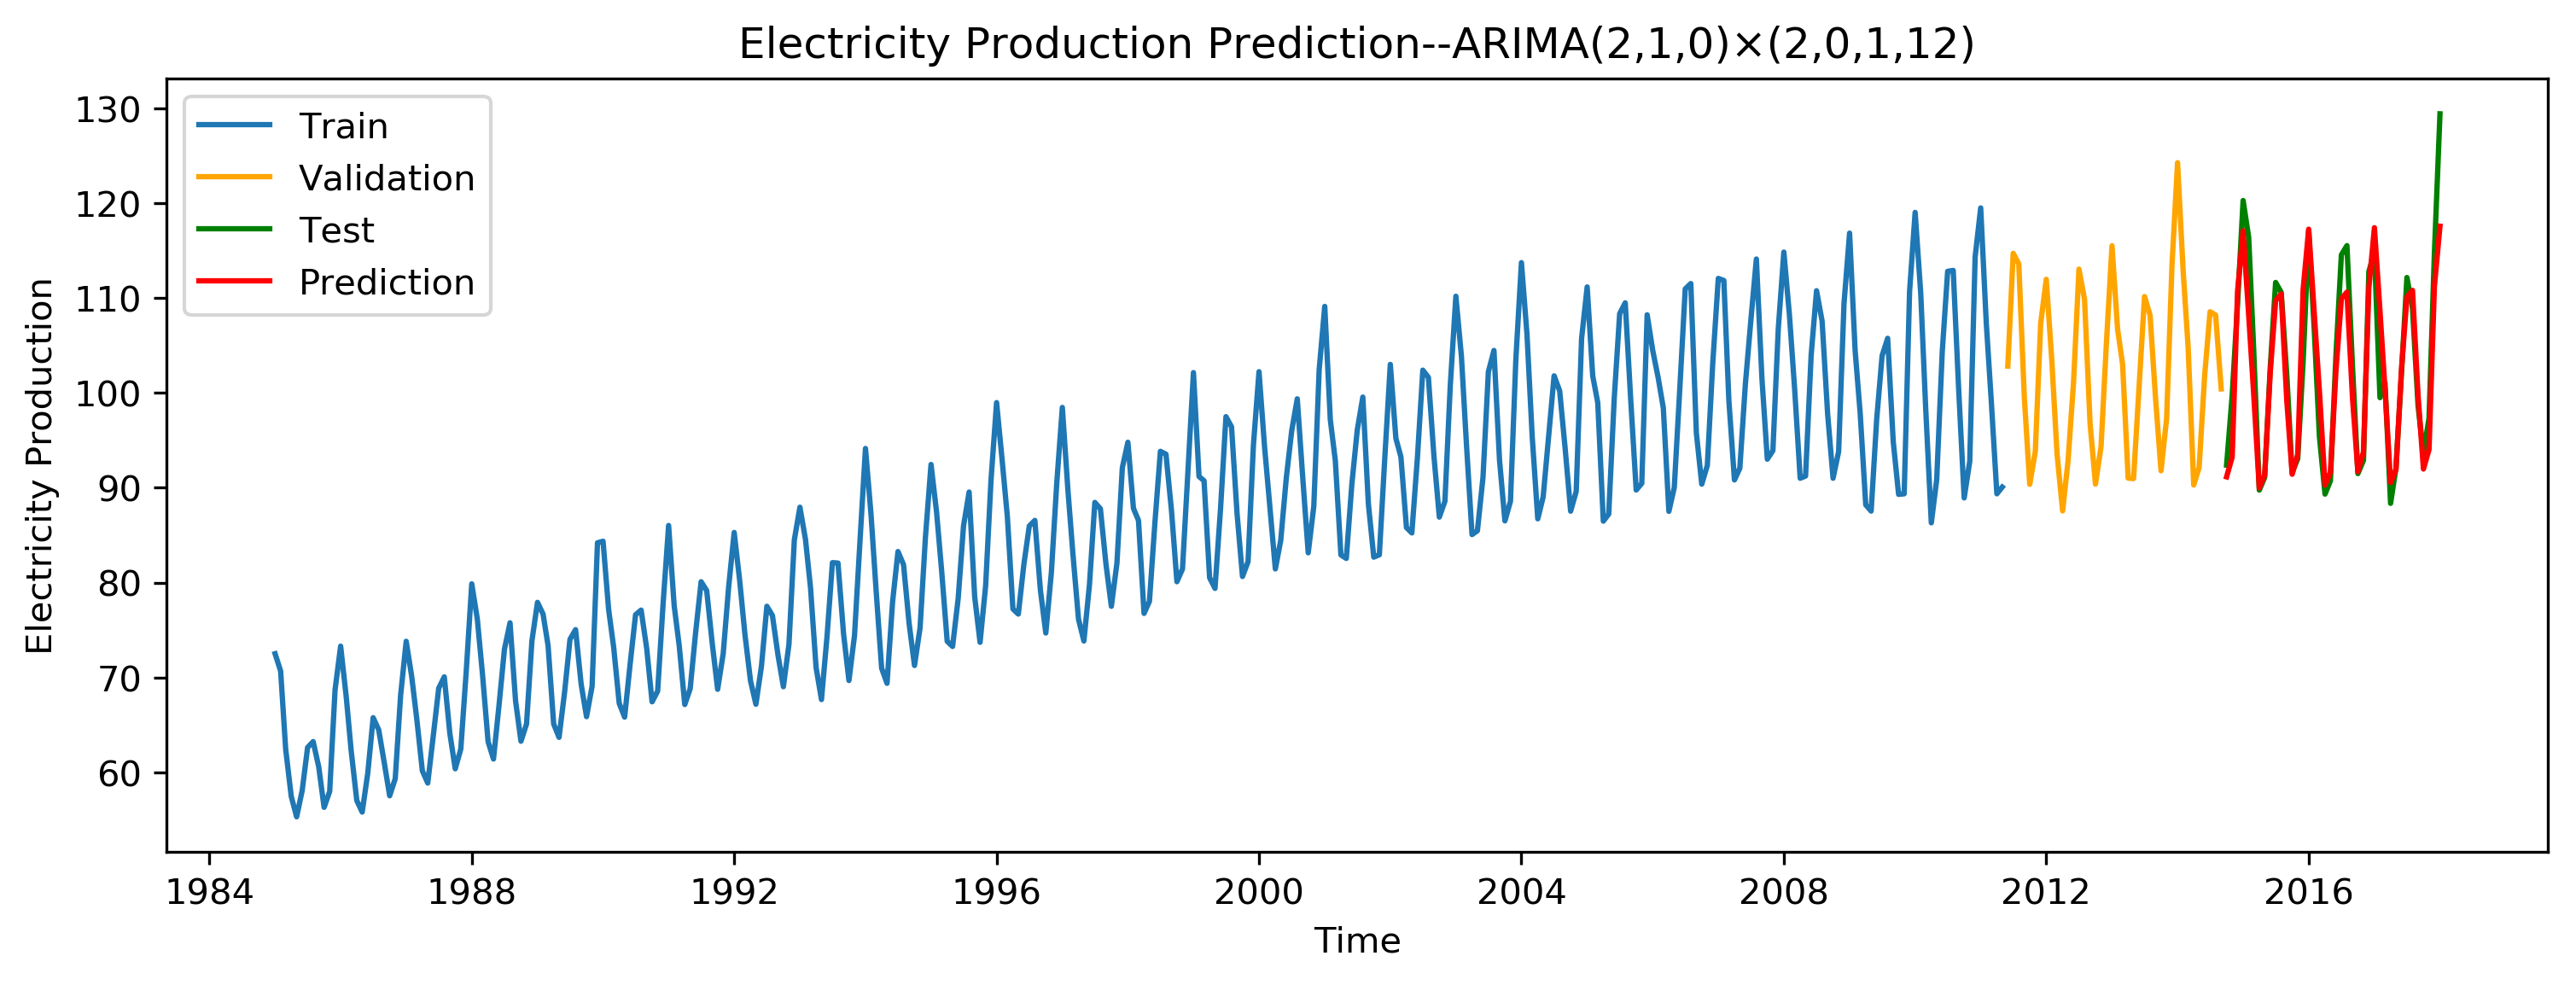

In [53]:
# s = pd.Series(pred_back,index = test_data.index)
s = pd.Series(pred_test,index = test_data.index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(train_data.Electricity, label='Train')
plt.plot(valid_data.Electricity, color = 'orange', label='Validation')
plt.plot(test_data.Electricity, color = 'green', label='Test')
plt.plot(s, color = 'red',label='Prediction')
plt.title('Electricity Production Prediction--ARIMA(2,1,0)×(2,0,1,12)')
plt.xlabel('Time')
plt.ylabel('Electricity Production')
plt.legend(loc='upper left', fontsize=10)
plt.savefig('elec_pred')
plt.show()

In [49]:
rmse_test = math.sqrt(mean_squared_error(test_data.Electricity, pred_test.tolist()))
print('RMSE: '+str(rmse_test))
smape_test = np.mean(2*np.abs(pred_test.tolist()-test_data.Electricity)/(np.abs(pred_test.tolist())+np.abs(test_data.Electricity)))
print('SMAPE: '+str(smape_test))


RMSE: 3.786449446202348
SMAPE: 0.024775121148222477


In [459]:
d = {'RMSE':np.round(rmse,4),'SMAPE':np.round(smape,4)}
pd.DataFrame(d,index = [1])

,RMSE,SMAPE
1,4.087,0.0316


In [462]:
l = [np.abs(test_data.Electricity.tolist()[i]-pred.tolist()[i]) for i in range(len(pred_back))]

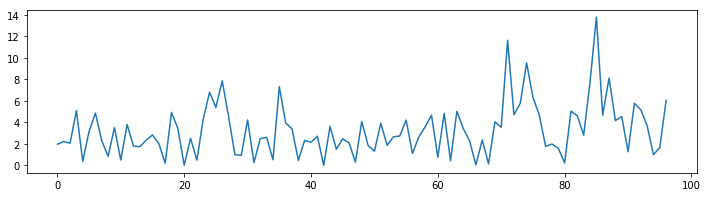

In [463]:
plt.figure(figsize = (12,3))
plt.plot(l)

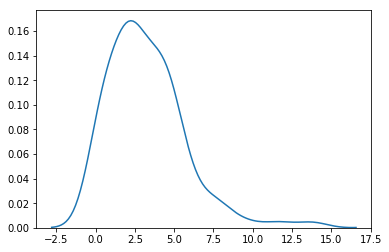

In [464]:
import seaborn as sns
sns.distplot(l, hist = False)

In [121]:
def evaluate_arima_model(train,test, arima_order):
    try:
        model = ARIMA(train, order=arima_order).fit(disp=-1)
        pred = model.forecast(97,alpha=0.05)[0]
        error = mean_squared_error(test, pred)
        return error
    except:
        return float('inf')



In [122]:
def tune_models(train,test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                mse = evaluate_arima_model(train,test, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order

                    print('ARIMA%s MSE=%.3f' % (order,mse))
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [123]:
p_values = [1,2,3,4,5]
d_values = [0,1]
q_values = [1,2]
tune_models(train_data_log,test_data_log, p_values, d_values, q_values)

(1, 0, 1)
ARIMA(1, 0, 1) MSE=0.045
(1, 0, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2) MSE=0.010
(1, 1, 1)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(1, 1, 2)
(2, 0, 1)
(2, 0, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2) MSE=0.010
(2, 1, 1)
(2, 1, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(3, 0, 1)
(3, 0, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 0, 2) MSE=0.004
(3, 1, 1)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(3, 1, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(4, 0, 1)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(4, 0, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(4, 1, 1)
(4, 1, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(5, 0, 1)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(5, 0, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(5, 1, 1)
(5, 1, 2)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Best ARIMA(3, 0, 2) MSE=0.004


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
